In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve,
    accuracy_score, precision_score, recall_score
)

In [93]:
CSV_PATH = "data.csv" 
TARGET_COL = "Bankrupt?" 

np.random.seed(42)
os.makedirs("plots", exist_ok=True)

def save_and_show(filename):
    plt.savefig(f"plots/{filename}", bbox_inches="tight")
    plt.show()

In [94]:
def load_dataset(csv_path, target_col):
    df = pd.read_csv(csv_path)
    df.rename(columns=lambda s: s.strip(), inplace=True)

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Columns: {list(df.columns)}")

    X_df = df.drop(columns=[target_col]).copy()
    y = df[target_col].astype(int).values.reshape(-1, 1)

    for c in X_df.columns:
        X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
    X_df = X_df.apply(lambda col: col.fillna(col.median()))

    return X_df.values, y, X_df.columns

def scale_split_sets(a, b, c):
    s = StandardScaler()
    a_s = s.fit_transform(a)
    b_s = s.transform(b)
    c_s = s.transform(c)
    return a_s, b_s, c_s, s

In [95]:
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1 / (1 + np.exp(-z))


def ini_param(d):
    return np.zeros((d, 1)), 0.0

def fit_logistic_batches(X, y, w, b, lr, epochs, batch):
    n = X.shape[0]
    losses = []
    for _ in range(epochs):
        idx = np.random.permutation(n)
        X = X[idx]; y = y[idx]
        for i in range(0, n, batch):
            xb = X[i:i+batch]; yb = y[i:i+batch]
            z = xb @ w + b
            h = sigmoid(z)
            dw = (xb.T @ (h - yb)) / xb.shape[0]
            db = np.mean(h - yb)
            w -= lr * dw; b -= lr * db
        p = sigmoid(X @ w + b)
        loss = -np.mean(y * np.log(p + 1e-8) + (1-y) * np.log(1-p + 1e-8))
        losses.append(loss)
    return w, b, losses

def predict(X, w, b, thr=0.5):
    return (sigmoid(X @ w + b) >= thr).astype(int)

In [96]:
def metric_summary(y_true, probs, thr=0.5):
    preds = (probs >= thr).astype(int)
    y_true_1d = y_true.reshape(-1)
    preds_1d = preds.reshape(-1)

    acc = accuracy_score(y_true_1d, preds_1d)
    prec = precision_score(y_true_1d, preds_1d, zero_division=0)
    rec = recall_score(y_true_1d, preds_1d, zero_division=0)
    cm = confusion_matrix(y_true_1d, preds_1d)

    return {"accuracy": acc, "precision": prec, "recall": rec, "cm": cm, "preds": preds_1d}

In [97]:
def best_params(Xt, yt, Xv, yv, lr_list, ep_list, bs_list):
    best_acc = -1
    best_cfg = None
    best_w = None
    best_b = None
    best_losses = None
    grid_acc = []

    for lr in lr_list:
        row = []
        for ep in ep_list:
            w, b = ini_param(Xt.shape[1])
            w, b, losses = fit_logistic_batches(Xt, yt, w, b, lr, ep, bs_list[0])
            preds = predict(Xv, w, b)
            acc = np.mean(yv.reshape(-1) == preds.reshape(-1))
            row.append(acc)
            if acc > best_acc:
                best_acc = acc
                best_cfg = (lr, ep, bs_list[0])
                best_w, best_b = w, b
                best_losses = losses
        grid_acc.append(row)

    return best_w, best_b, best_cfg, best_acc, best_losses, np.array(grid_acc)

In [99]:
if __name__ == "__main__":

    X_all, y_all, feature_names = load_dataset(CSV_PATH, TARGET_COL)
    X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
        X_all, y_all, test_size=0.3, stratify=y_all, random_state=42
    )
    X_val_raw, X_test_raw, y_val, y_test = train_test_split(
        X_temp_raw, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    X_train, X_val, X_test, scaler = scale_split_sets(X_train_raw, X_val_raw, X_test_raw)

    lr_list = [0.0001, 0.0005, 0.001]
    epoch_list = [500, 1000, 1500]
    batch_list = [64]

    w, b, params, val_acc, best_losses, grid_mat = best_params(
        X_train, y_train, X_val, y_val, lr_list, epoch_list, batch_list
    )

    val_probs = sigmoid(X_val @ w + b)
    thresholds = np.linspace(0.01, 0.99, 99)
    best_thr, best_f1 = 0.5, -1.0
    yv = y_val.reshape(-1)

    for t in thresholds:
        preds_t = (val_probs >= t).astype(int).reshape(-1)
        p = precision_score(yv, preds_t, zero_division=0)
        r = recall_score(yv, preds_t, zero_division=0)
        f1 = 2 * p * r / (p + r + 1e-8)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(t)

    print(f"\nChosen decision threshold (from validation): {best_thr:.3f}")

    
    test_probs = sigmoid(X_test @ w + b)
    yt = y_test.reshape(-1)
    test_preds_tuned = (test_probs >= best_thr).astype(int).reshape(-1)
    acc_t = accuracy_score(yt, test_preds_tuned)
    prec_t = precision_score(yt, test_preds_tuned, zero_division=0)
    rec_t  = recall_score(yt, test_preds_tuned, zero_division=0)

    print("\n=== TEST METRICS (tuned threshold) ===")
    print(f"Accuracy : {acc_t:.4f}")
    print(f"Precision: {prec_t:.4f}")
    print(f"Recall   : {rec_t:.4f}")

    best_row = {
        "model": "LogisticRegression (scratch)",
        "learning_rate": params[0],
        "epochs": params[1],
        "batch_size": params[2],
        "decision_threshold": best_thr,
        "validation_accuracy": float(val_acc),
        "test_accuracy": float(acc_t),
        "test_precision": float(prec_t),
        "test_recall": float(rec_t)
    }
    pd.DataFrame([best_row]).to_csv("best_model_summary.csv", index=False)
    print("\nSaved: best_model_summary.csv")


Chosen decision threshold (from validation): 0.200

=== TEST METRICS (tuned threshold) ===
Accuracy : 0.9589
Precision: 0.3548
Recall   : 0.3333

Saved: best_model_summary.csv


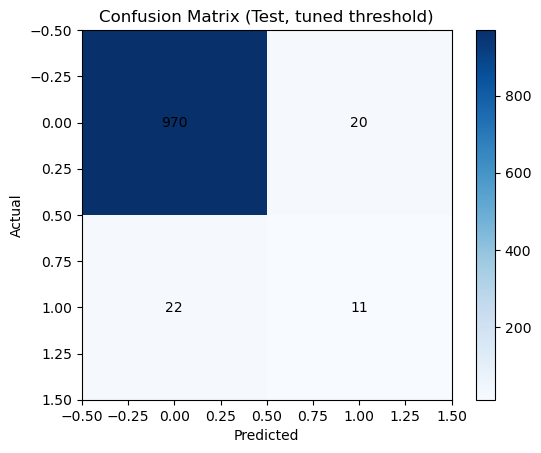

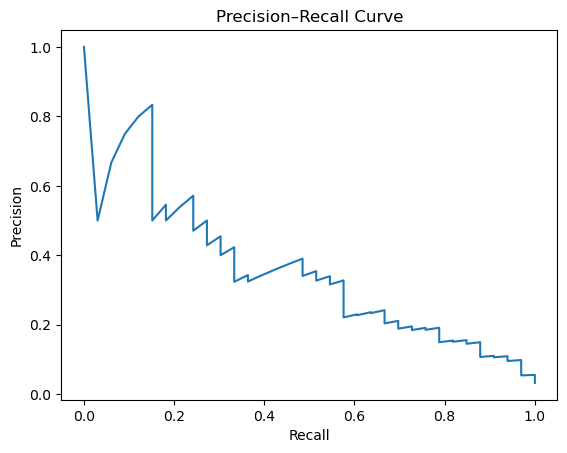

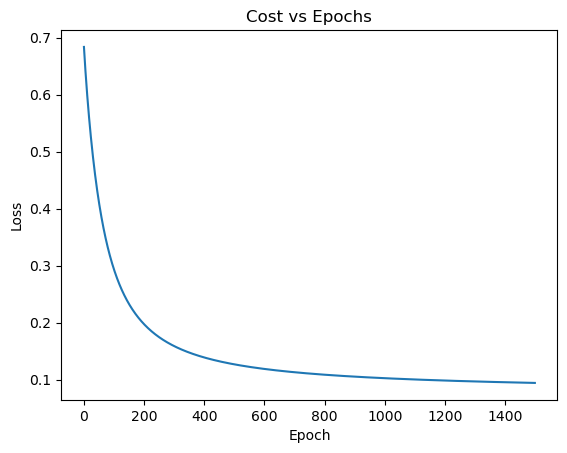

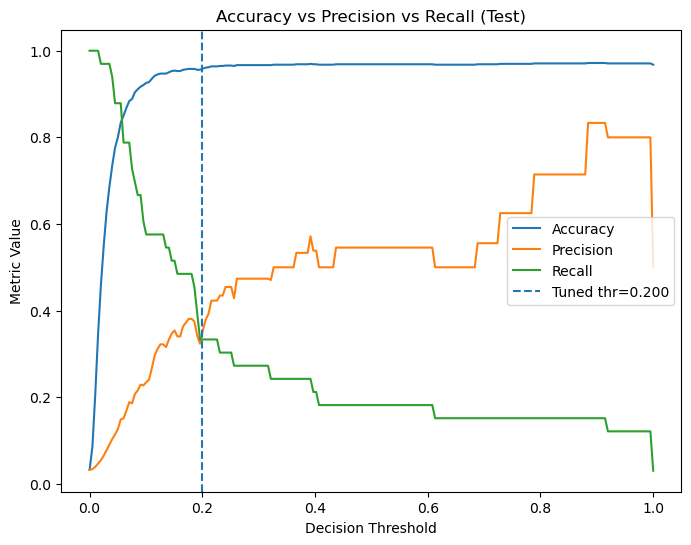

In [100]:

cm = confusion_matrix(yt, test_preds_tuned)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test, tuned threshold)")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
save_and_show("confusion_matrix.png")



prec_curve, rec_curve, _ = precision_recall_curve(yt, test_probs)
plt.plot(rec_curve, prec_curve)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
save_and_show("precision_recall_curve.png")



plt.plot(best_losses)
plt.title("Cost vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
save_and_show("loss_curve.png")



thresholds_plot = np.linspace(0, 1, 200)
accs, precs, recs = [], [], []

for t in thresholds_plot:
    preds_t = (test_probs >= t).astype(int).reshape(-1)
    accs.append(accuracy_score(yt, preds_t))
    precs.append(precision_score(yt, preds_t, zero_division=0))
    recs.append(recall_score(yt, preds_t, zero_division=0))

plt.figure(figsize=(8, 6))
plt.plot(thresholds_plot, accs, label="Accuracy")
plt.plot(thresholds_plot, precs, label="Precision")
plt.plot(thresholds_plot, recs, label="Recall")
plt.axvline(best_thr, linestyle="--", label=f"Tuned thr={best_thr:.3f}")

plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("Accuracy vs Precision vs Recall (Test)")
plt.legend()
save_and_show("acc_prec_rec_comparison.png")


In [101]:
def prediction_system(input_tuple, feature_names, scaler, w, b, threshold=0.5):
    if len(input_tuple) != len(feature_names):
        raise ValueError(f"Expected {len(feature_names)} features, got {len(input_tuple)}.")
    arr = np.asarray(input_tuple, dtype=float).reshape(1, -1)
    std_arr = scaler.transform(arr)
    prob = float(sigmoid(std_arr @ w + b)[0, 0])
    pred = int(prob >= threshold)
    return prob, pred, std_arr

In [102]:
input_data_1 = (
        0.487398235, 0.543720017, 0.533647412, 0.63625881, 0.636251604,
        0.999041651, 0.797443551, 0.809340436, 0.303467002, 0.781598606,
        0.00061137, 0, 0.465163601, 0.000550055, 0.441643891, 0.176478025,
        0.176478025, 0.176478025, 0.217452964, 0.319905213, 0.020055356,
        0.102760362, 0.174512315, 0.0220848, 0.847986149, 0.689233838,
        0.689233838, 0.217571523, 6250000000, 0.00044556, 0.2636921,
        0.378497448, 0.013358461, 0.008200383, 0.631267722, 0.003253723,
        0.077485866, 0.922514134, 0.005191807, 0.371230845, 0.005365848,
        0.102757015, 0.173531408, 0.398864987, 0.11844078, 0.001164619,
        0.005434277, 40300000, 0.000136926, 0.026451613, 0.004873463,
        0.393252075, 0.004596355, 0.809073201, 0.249596686, 0.386907211,
        0.093503139, 0.008371469, 0.009000166, 0.054771596, 0.348128382,
        0.277320828, 0.013225565, 0.653827592, 0.735200728, 0.328140542,
        0.001772228, 0.933563971, 0.002242858, 0.087295963, 0.000122691,
        8050000000, 0.593965944, 8490000000, 0.671578992, 0.453055477,
        0.653827592, 0.328140542, 0.111816398, 0.652471662, 0.462332138,
        0.583805485, 0.315775233, 0.021936861, 0, 0.802551849, 0.001521377,
        0.623762891, 0.636255941, 0.840455976, 0.277138799, 0.026924264,
        0.565722078, 1, 0.049622455
    )

input_data_2 = (
        0.462194706, 0.53603358, 0.514427967, 0.599987028, 0.599987028,
        0.998908888, 0.797290547, 0.809222607, 0.303477395, 0.781367728,
        0.000162469, 0, 0.458983585, 0.000943094, 0, 0.145505878,
        0.145505878, 0.145505878, 0.202514891, 0.312690104, 0.013581983,
        0.091930625, 0.165549446, 0.022950998, 0.848122635, 0.688191178,
        0.687989374, 0.217611038, 6430000000, 0.000417811, 0.263748825,
        0.370291718, 0.00212355, 0.001388669, 0.64852365, 0.030692419,
        0.228890165, 0.771109835, 0.004879739, 0.396528161, 0.005365848,
        0.091911346, 0.164565267, 0.403180234, 0.064467766, 0.001345196,
        0.004698207, 0.000116172, 4840000000, 0.037419355, 0.012308506,
        0.389814794, 0.031878627, 0.673325141, 0.105993835, 0.172224525,
        0.011060914, 0.001305564, 0.000415664, 0.141036558, 0.336370895,
        0.276849113, 0.002469446, 0.586269037, 0.718087877, 0.342348548,
        0.027677719, 0.868460717, 0.002162379, 0.022401707, 0.000101455,
        6420000000, 0.593788636, 1870000000, 0.671576937, 0.669737404,
        0.586269037, 0.342348548, 0.130978633, 0.64648698, 0.459674631,
        0.533221122, 0.316005968, 0.12488271, 0, 0.787081562, 0.00163072,
        0.62187648, 0.599983644, 0.838258502, 0.297038121, 0.024885858,
        0.576472531, 1, 0.014561571
    )

    
prob1, pred1, std1 = prediction_system(input_data_1, feature_names, scaler, w, b, threshold=best_thr)
print("\nStandardized input 1 (first 5 features):", std1[0][:5], "...")
print("Input 1 -> prob:", prob1, "| pred:", pred1, "|", "The Company is BANKRUPT (1)" if pred1==1 else "The Company is NOT BANKRUPT (0)")

prob2, pred2, std2 = prediction_system(input_data_2, feature_names, scaler, w, b, threshold=best_thr)
print("Standardized input 2 (first 5 features):", std2[0][:5], "...")
print("Input 2 -> prob:", prob2, "| pred:", pred2, "|", "The Company is BANKRUPT (1)" if pred2==1 else "The Company is NOT BANKRUPT (0)")



Standardized input 1 (first 5 features): [-0.2770593  -0.20904101 -0.30755873  1.67386297  1.67635098] ...
Input 1 -> prob: 0.014331699899848085 | pred: 0 | The Company is NOT BANKRUPT (0)
Standardized input 2 (first 5 features): [-0.69112848 -0.32566468 -0.61686028 -0.45465926 -0.45393574] ...
Input 2 -> prob: 0.2236049832454702 | pred: 1 | The Company is BANKRUPT (1)
